In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import cm
import os
import stumpy
from scipy import interpolate
from scipy.cluster.hierarchy import linkage, dendrogram

plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')

# Discovering motifs under uniform scaling
This tutorial explores the "Discovering motifs under uniform scaling" case study from the research paper:  
[The Swiss Army Knife of Time Series Data Mining: Ten Useful Things You Can Do with the Matrix Profile and Ten Lines of Code (see Section 3.1)"](https://www.cs.ucr.edu/~eamonn/Top_Ten_Things_Matrix_Profile.pdf).[1]

### Optimal squared Euclidean distance (uniform scaling)
Suppose that we have a query time series $Q = (q_1, q_2,.....,q_{m_q})$, and candidate matching sequence $C = (c_1, c_2,.....,c_{m_c})$.  

Without loss of generality, assume that $m_q \leq m_c$

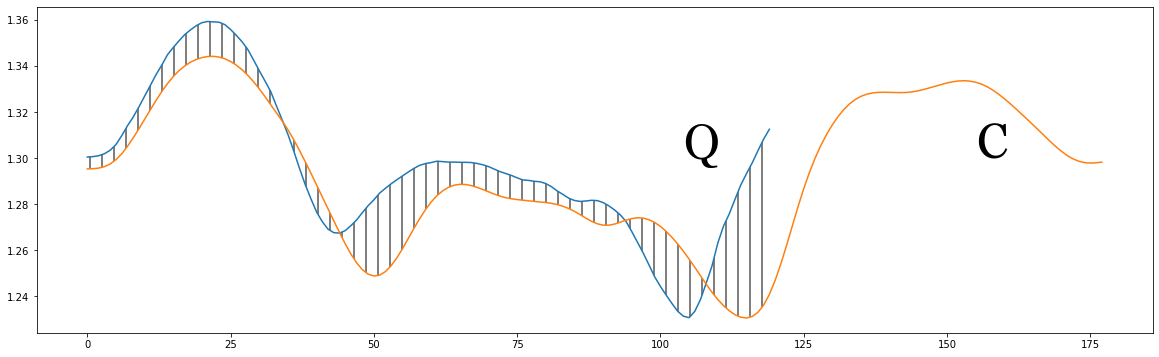

In [39]:
Q = pd.read_pickle("31_1_yankov2_red.csv")
C = pd.read_pickle("31_1_yankov2_blue.csv")
x_Q = np.arange(len(Q))
C_ = C[:len(Q)]
d = np.linalg.norm(Q-C[:len(Q)]) # euclidean distance

fontd_ = {"family" : "Georgia"}
plt.plot(Q)
plt.plot(C, color="C1")
plt.fill_between(x_Q, Q, C_, facecolor='white', hatch="|", interpolate=True)
plt.text(104, 1.30, "Q", fontsize=48, fontdict=fontd_)
plt.text(155, 1.30, "C", fontsize=48, fontdict=fontd_)
plt.show()

$Q$ and $C$ have similar signal pattern but,
Comparing $Q$ and $C$ directly yields larger Euclidean distance.

Streching $Q$ ($Q^{s}$) should be more close.  

$Q^{s}$ series length is as $s$.  
A uniformly scaled version of the query $Q$ with scaling factor $\frac {m_q}{s}$ is the time series $Q^s = (q ^{s}_{1}, q ^{s}_{1},.....,q ^{s}_{\frac {m_q}{s}})$, where $q ^{s}_{i} = q_{i \frac {m_q}{s}}$.  

We have to search best scaling factor to minimize Euclidean distance by the uniform scaling.  
The uniform scaling distance $d_{u}(Q, C)$ is defined as optimal squared Euclidean distance between some prefix of $C$ with length $s >= m_{q}$  
and query scaled to the size of that prefix. Or more formally:


$$
\begin{align}  
    d_{u}(Q, C) ={}&
        \min _{m_{q} \leq {s} \leq m_{c}}{
            \sum_{i=1}^{s} ( q^s_{i} - c^s_{i})^2
        }
\end{align}
$$

In [43]:
mq, mc = len(Q), len(C)
range_scaling = np.arange(1, mc/mq, 0.01)

du = []  # euclidean distance
for i_scale in range_scaling:
    fitted_curve = interpolate.PchipInterpolator(x_Q, Q)
    x_dummy = np.arange(0, len(Q), i_scale)
    Qs = fitted_curve(x_dummy)
    du.append(np.linalg.norm(Qs-C[:len(Qs)]))

scaling_factor = range_scaling[np.argmin(du)]

print(f"scaling factor for minimum Euclidean distance is {scaling_factor:.2f}")
print(f"Euclidean distance is improved to {np.min(du):.3f} from {d:.3f}")

scaling factor for minimum Euclidean distance is 1.15
Euclidean distance is improved to 0.240 from 0.242


Let's see original data and streached data.

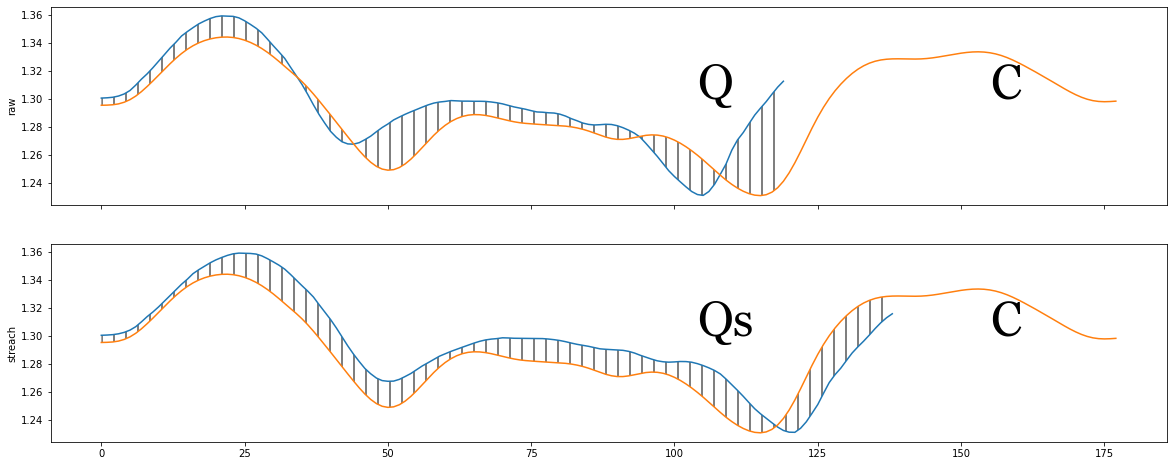

In [49]:
# uniform scaling
fitted_curve = interpolate.PchipInterpolator(x_Q, Q)
x_dummy = np.arange(0, len(Q), 1/scaling_factor)

Qs = fitted_curve(x_dummy)
x_Qs = np.arange(len(Qs))
Cs_ = C[:len(Qs)]

# plot
_, axes = plt.subplots(2, 1, sharex=True, figsize=(20, 8))
fontd_ = {"family" : "Georgia"}
axes[0].plot(Q)
axes[0].plot(C, color="C1")
axes[0].fill_between(x_Q, Q, C_,
                facecolor='white', hatch="|", interpolate=True)
axes[0].text(104, 1.30, "Q", fontsize=48, fontdict=fontd_)
axes[0].text(155, 1.30, "C", fontsize=48, fontdict=fontd_)
axes[0].set_ylabel("raw")

axes[1].plot(Qs)
axes[1].plot(C, color="C1")
axes[1].fill_between(x_Qs, Qs, Cs_,
                facecolor='white', hatch="|", interpolate=True)
axes[1].text(104, 1.30, "Qs", fontsize=48, fontdict=fontd_)
axes[1].text(155, 1.30, "C", fontsize=48, fontdict=fontd_)
axes[1].set_ylabel("streach")
plt.show()


Stretching $Q$ with 15% produces $Q_s$ which resembles very closely the prefix of $C$.

### Uniform scaling with Matrix Profile

Scaling logic above can be appiled to Matrix Profile simply.  
Here is a random walk time series for demostration from the MALLAT dataset and Matrix profile caluculation by `stumpy.stump`.  
After checking Mtrix profile with raw dataset out, Let's demonstrate.

In [12]:
T = pd.read_pickle("31_1_MALLAT.csv") 
m = 1024  # window size

l = len(T)
x = np.arange(l)
mp = stumpy.stump(T, m)
idx_a = np.argmin(mp[:, 0])
idx_b = mp[:, 1][idx_a]

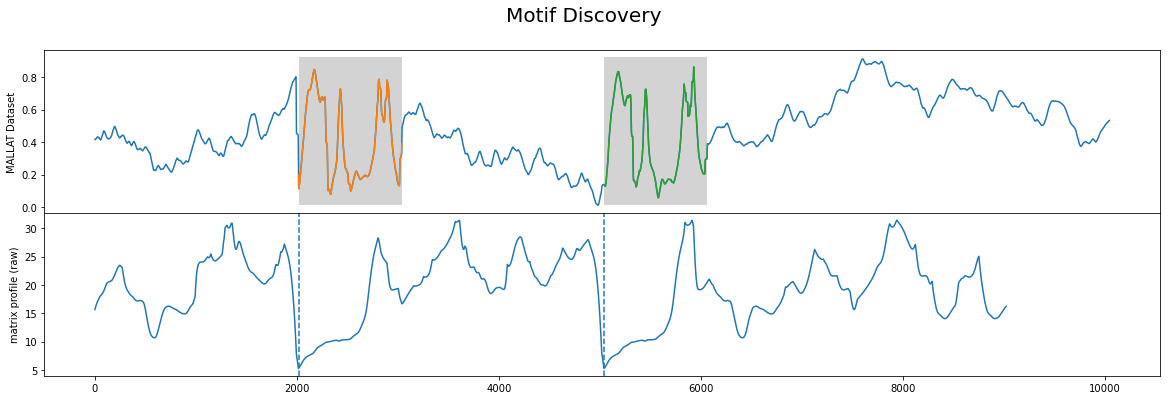

In [13]:
fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Motif Discovery', fontsize='20')
axs[0].plot(T)
axs[0].plot(x[idx_a:idx_a+m], T[idx_a:idx_a+m])
axs[0].plot(x[idx_b:idx_b+m], T[idx_b:idx_b+m])
axs[0].set_ylabel("MALLAT Dataset")
rect = Rectangle((idx_a, np.min(T)), m, np.max(T), facecolor='lightgrey')
axs[0].add_patch(rect)
rect = Rectangle((idx_b, np.min(T)), m, np.max(T), facecolor='lightgrey')
axs[0].add_patch(rect)

axs[1].plot(mp[:, 0])
axs[1].axvline(idx_a, linestyle="dashed")
axs[1].axvline(idx_b, linestyle="dashed")
axs[1].set_ylabel("matrix profile (raw)")
plt.show()

The color highlighting indicates top-1 motif, which unsurprisingly are exactly the imbedded patterns.  
The matrix profile corresponding to the random walk time series. The minimum values correspond to the top-1 motif in the time series.

Let's demonstrate how unifrom scaling can affect motif discovery in **streaching case(1)** and **shrking case(2)**.



### 1. Streaching
The searched scaling range is `150% ~ 180%` as an illustrative example.

In [16]:
range_scaling = np.arange(1.5, 1.8, 0.01)
l_ = len(T) - m + 1

P_updated = np.full(l_, np.inf, dtype=np.float64)
I_updated = np.zeros(l_, dtype=np.float64)
minScale = np.full(l_, np.nan, dtype=np.float64)

x_T = np.arange(len(T))
fitted_curve = interpolate.PchipInterpolator(x_T, T)

# Search scaling factor
for scale_factor in range_scaling:
    stretch_scale = 1 / scale_factor
    x_dummy = np.arange(0, len(x_T), stretch_scale)
    Ts = fitted_curve(x_dummy)

    mp = stumpy.stump(T, m, Ts, ignore_trivial=False)
    mask = mp[:, 0] < P_updated
    P_updated[mask] = mp[mask, 0]
    I_updated[mask] = mp[mask, 1]
    minScale[mask] = scale_factor

idx_min = np.argmin(P_updated)

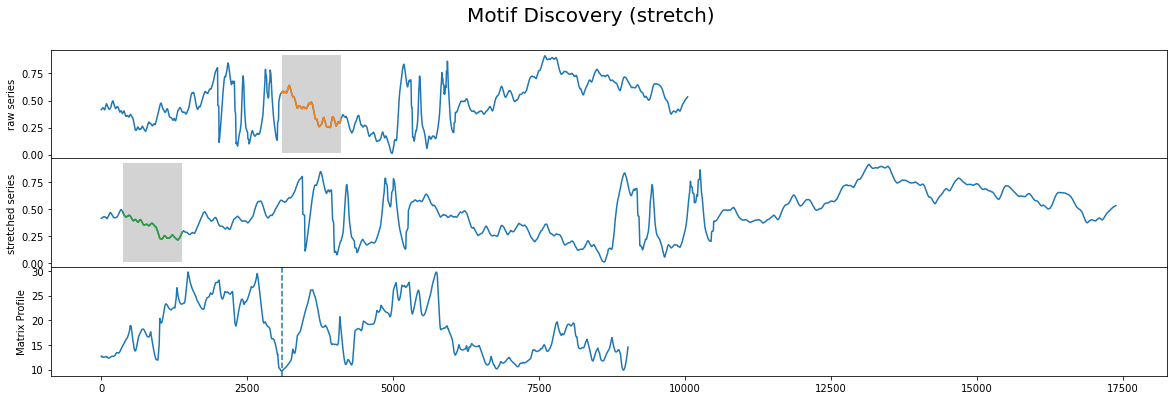

In [7]:
# stretched series re-calculation
scale_factor = minScale[idx_min]
stretch_scale = 1 / scale_factor
x_dummy = np.arange(0, len(x_T), stretch_scale)
Ts = fitted_curve(x_dummy)
x_Ts = np.arange(len(Ts))

idx_min_s = int(I_updated[idx_min])

fig, axs = plt.subplots(3, 1, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Motif Discovery (stretch)', fontsize='20')
axs[0].plot(T)
axs[0].plot(x_T[idx_min:idx_min+m], T[idx_min:idx_min+m])
rect = Rectangle((idx_min, np.min(T)), m, np.max(T), facecolor='lightgrey')
axs[0].add_patch(rect)
axs[0].set_ylabel("Raw series")

axs[1].plot(Ts)
axs[1].plot(x_Ts[idx_min_s:idx_min_s+m], Ts[idx_min_s:idx_min_s+m], color="C2")
rect = Rectangle((idx_min_s, np.min(Ts)), m, np.max(Ts), facecolor='lightgrey')
axs[1].add_patch(rect)
axs[1].set_ylabel("Stretched series")

axs[2].plot(P_updated)
axs[2].axvline(idx_min, color="C0", linestyle="--")
axs[2].set_ylabel("Matrix Profile")

plt.show()

### 2. Shrinking
The searched scaling range is `30% ~ 70%` as an illustrative example.

In [14]:
range_scaling = np.arange(0.3, 0.7, 0.01)
l_ = len(T) - m + 1

P_updated = np.full(l_, np.inf, dtype=np.float64)
I_updated = np.zeros(l_, dtype=np.float64)
minScale = np.full(l_, np.nan, dtype=np.float64)

x_T = np.arange(len(T))
fitted_curve = interpolate.PchipInterpolator(x_T, T)

# Search scaling factor
for scale_factor in range_scaling:
    stretch_scale = 1 / scale_factor
    x_dummy = np.arange(0, len(x_T), stretch_scale)
    Ts = fitted_curve(x_dummy)

    mp = stumpy.stump(T, m, Ts, ignore_trivial=False)
    mask = mp[:, 0] < P_updated
    P_updated[mask] = mp[mask, 0]
    I_updated[mask] = mp[mask, 1]
    minScale[mask] = scale_factor

idx_min = np.argmin(P_updated)

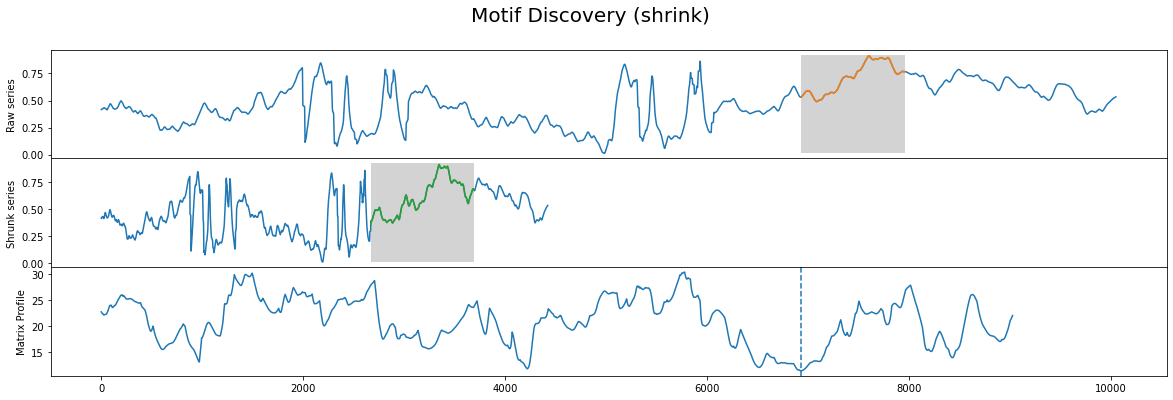

In [15]:
# shrunk series re-calculation
scale_factor = minScale[idx_min]
stretch_scale = 1 / scale_factor
x_dummy = np.arange(0, len(x_T), stretch_scale)
Ts = fitted_curve(x_dummy)
x_Ts = np.arange(len(Ts))

idx_min_s = int(I_updated[idx_min])

fig, axs = plt.subplots(3, 1, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Motif Discovery (shrink)', fontsize='20')
axs[0].plot(T)
axs[0].plot(x_T[idx_min:idx_min+m], T[idx_min:idx_min+m])
rect = Rectangle((idx_min, np.min(T)), m, np.max(T), facecolor='lightgrey')
axs[0].add_patch(rect)
axs[0].set_ylabel("Raw series")

axs[1].plot(Ts)
axs[1].plot(x_Ts[idx_min_s:idx_min_s+m], Ts[idx_min_s:idx_min_s+m], color="C2")
rect = Rectangle((idx_min_s, np.min(Ts)), m, np.max(Ts), facecolor='lightgrey')
axs[1].add_patch(rect)
axs[1].set_ylabel("Shrunk series")

axs[2].plot(P_updated)
axs[2].axvline(idx_min, color="C0", linestyle="--")
axs[2].set_ylabel("Matrix Profile")

plt.show()

Now, the resulting Matrix Profile will discover the motifs with the appropriate uniform scaling invariance.  
To the best of our knowledge, there is only one research effort that has addressed this (Yankov 2007)[2]. However, this method is approximate, requires many parameters to be set,  
and is only able to support a limited range of scaling.  In contrast, we can easily and exactly solve this problem under our simple assumptions.

This example perfectly elucidates the philosophy driving this paper.  
For many time series data mining tasks, we may not need to spend significant human time
designing, implementing and tuning new algorithms.  
The Matrix Profile and ten lines of code may be sufficient.

## References
[1]: [The Swiss Army Knife of Time Series Data Mining: Ten Useful Things You Can Do With The Matrix Profile And Ten Lines Of Code](https://www.cs.ucr.edu/~eamonn/Top_Ten_Things_Matrix_Profile.pdf) (see Section 3.1)

[2]: Yankov 2007: [Detecting time series motifs under uniform scaling. In: Proceedings of the 2007 ACM SIGKDD](https://dl.acm.org/doi/10.1145/1281192.1281282)  